In [72]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import numpy as np
import random
import networkx
import itertools
import copy
import collections

In [73]:
size = 100
points = size*np.random.random((size**2,2))
poly_map = Voronoi(points)

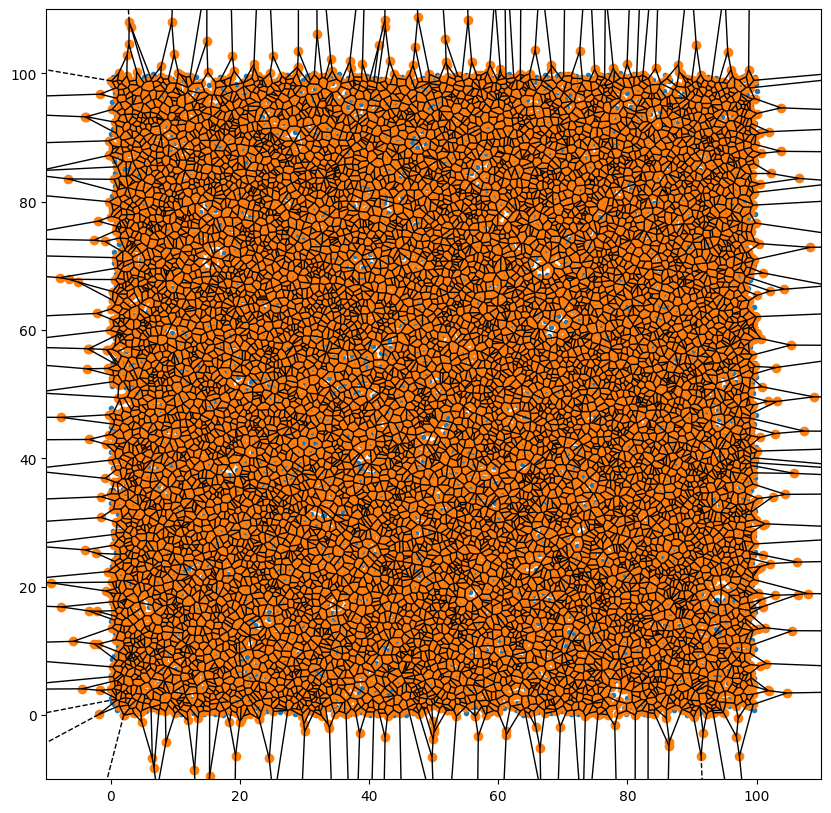

In [74]:
fig = voronoi_plot_2d(poly_map)
fig.set_size_inches(10, 10)
plt.show()


In [75]:
def check(vertices):
    for couple in vertices:
        if (any(x < 0 or x > size for x in couple)):
            return False
    return True

In [76]:
def lloyd_relax(self, times):
        for i in range(times):
            centroids = []
            for region in self.regions:
                if (region != []):
                    vertices = self.vertices[region]
                    if (check(vertices)):
                        centroid_x = np.sum(vertices[:, 0])/vertices.shape[0]
                        centroid_y = np.sum(vertices[:, 1])/vertices.shape[0]
                        centroid = [centroid_x, centroid_y]
                        centroids.append(centroid)
            points = centroids
            vor = Voronoi(points)
        return vor

In [77]:
lloyd = lloyd_relax(poly_map, 2)

In [78]:
cell_network = networkx.Graph()

edges = {}

for i, region in enumerate(lloyd.regions):
    for edge in list(itertools.combinations(region,2)):
        if edge in edges:
            edges[edge].append(i)
            edges[edge[::-1]].append(i)
        else:
            edges[edge] = [i]
            edges[edge[::-1]] = [i]

for i in edges:
    for j in edges[i]:
        cell_network.add_node(j,height = -10, district = "", ter_type = "nat")
    if len(edges[i]) > 1:
        cell_network.add_edge(edges[i][0],edges[i][1])

##  remove nodes
new_net = copy.deepcopy(cell_network)

for node in cell_network.nodes:
    if not check(lloyd.vertices[lloyd.regions[node]]):
        new_net.remove_node(node)

cell_network = new_net

In [79]:
itterations = 10

#peak generation
peaks_locs = []

for i in range(itterations):
    peak = random.randint(int(cell_network.number_of_nodes()*0.3),int(cell_network.number_of_nodes()*0.7))
    if check(lloyd.vertices[lloyd.regions[peak]]):
        cell_network.nodes[peak]["height"] = random.randint(30,50)
        peaks_locs.append(peak)

In [80]:
def elevation_decrease(cell:int,complete_cells:list[int],elevation:int):
    new_cells = copy.deepcopy(complete_cells)
    for n in cell_network.neighbors(cell):
        if (n not in new_cells) or (cell_network.nodes[n]["height"] < elevation):
            if cell_network.nodes[n]["height"] < elevation:
                cell_network.nodes[n]["height"] = elevation
                new_cells.append(n)
                if elevation > -2:
                    elevation_decrease(n,new_cells,elevation-1)
        

In [81]:
for peak in peaks_locs: 
    elevation_decrease(peak,peaks_locs,cell_network.nodes[peak]["height"])

In [82]:
groups = {}

for i in cell_network.nodes:
    height = cell_network.nodes[i]["height"]
    if(check(lloyd.vertices[lloyd.regions[i]])):
        if height in groups:
            groups[height].append(Polygon(lloyd.vertices[lloyd.regions[i]]))
        else:
            groups[height] = [Polygon(lloyd.vertices[lloyd.regions[i]])]

groups = collections.OrderedDict(sorted(groups.items()))

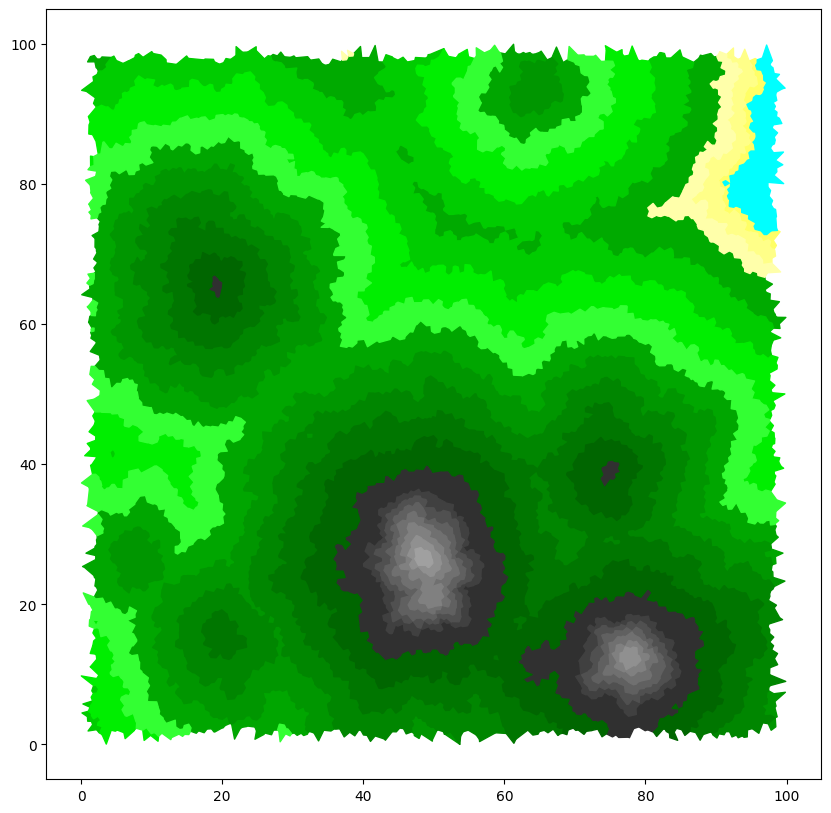

In [83]:
fig, ax = plt.subplots(1)
deep = []
water = []
hills = []
plains = []
beach = []
mountains = []

for i in groups:
    if i > 40:
        mountains.append(PatchCollection(groups[i]))
    elif i > 25:
        hills.append(PatchCollection(groups[i]))
    elif i > 10:
        plains.append(PatchCollection(groups[i]))
    elif i > 5:
        beach.append(PatchCollection(groups[i]))
    elif i > 0:
        water.append(PatchCollection(groups[i]))
    else:
        deep.append(PatchCollection(groups[i]))

mountains_colours = ["#FFFFFF","#F4F4F4","#F0F0F0","#E0E0E0","#D0D0D0","#C0C0C0","#B0B0B0","#A0A0A0","#909090","#808080","#707070","#606060","#505050","#404040","#303030","#303030","#303030"]
mountains_colours = mountains_colours[::-1]
for count, i in enumerate(mountains):
    ax.add_collection(i)
    i.set_color(mountains_colours[count])

hills_colours = ["#006600","#006600","#006600","#007600","#007600","#007600","#008600","#008600","#008600","#009600","#009600","#009600","#00A600","#00A600","#00A600"]
hills_colours = hills_colours[::-1]
for count, i in enumerate(hills):
    ax.add_collection(i)
    i.set_color(hills_colours[count])

plains_colours = [["#00AA00"],["#00AA00"],["#00AA00"],["#00AA00"],["#00CC00"],["#00CC00"],["#00CC00"],["#00CC00"],["#00EE00"],["#00EE00"],["#00EE00"],["#00EE00"],["#33FF33"],["#33FF33"],["#33FF33"],["#33FF33"]]
for count, i in enumerate(plains):
    ax.add_collection(i)
    i.set_color(plains_colours[count])

beach_colours = [["#FFFF66"],["#FFFF88"],["#FFFF88"],["#FFFFAA"],["#FFFFAA"]]
for count, i in enumerate(beach):
    ax.add_collection(i)
    i.set_color(beach_colours[count])

for i in water:
    ax.add_collection(i)
    i.set_color("#00FFFF")

for i in deep:
    ax.add_collection(i)
    i.set_color("#0000FF")

ax.autoscale_view()
fig.set_size_inches(10, 10)

In [99]:
def generate_district(cell:int,name:str,size:int):
    for n in cell_network.neighbors(cell):
        if (cell_network.nodes[n]["ter_type"] == "nat") and (cell_network.nodes[n]["district"] == "") and (cell_network.nodes[n]["height"] > 0) and (cell_network.nodes[n]["height"] < 20):
            cell_network.nodes[n]["district"] = name
            if size > 0:
                generate_district(n,name,size-1)

In [102]:
start = 0
for i in cell_network.nodes:
    if (cell_network.nodes[i]["height"] > 0) and (cell_network.nodes[i]["height"] < 20):
        start = i
        break

generate_district(start,"center",30)

counter = 0
for i in cell_network.nodes:
    if (cell_network.nodes[i]["height"] > 0) and (cell_network.nodes[i]["height"] < 20):
        start = i
        if counter == 16:
            break
        counter += 1

generate_district(start,"shop",20)

In [103]:
district_center = []
district_shop = []

for i in cell_network.nodes:
    district = cell_network.nodes[i]["district"]
    if(check(lloyd.vertices[lloyd.regions[i]])):
        if district != "center":
            district_center.append(Polygon(lloyd.vertices[lloyd.regions[i]]))
        if district != "shop":
            district_shop.append(Polygon(lloyd.vertices[lloyd.regions[i]]))

dtac = PatchCollection(district_center)
ax.add_collection(dtac)
dtac.set_color("#ff0000")

dtas = PatchCollection(district_shop)
ax.add_collection(dtas)
dtas.set_color("#ffff00")


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


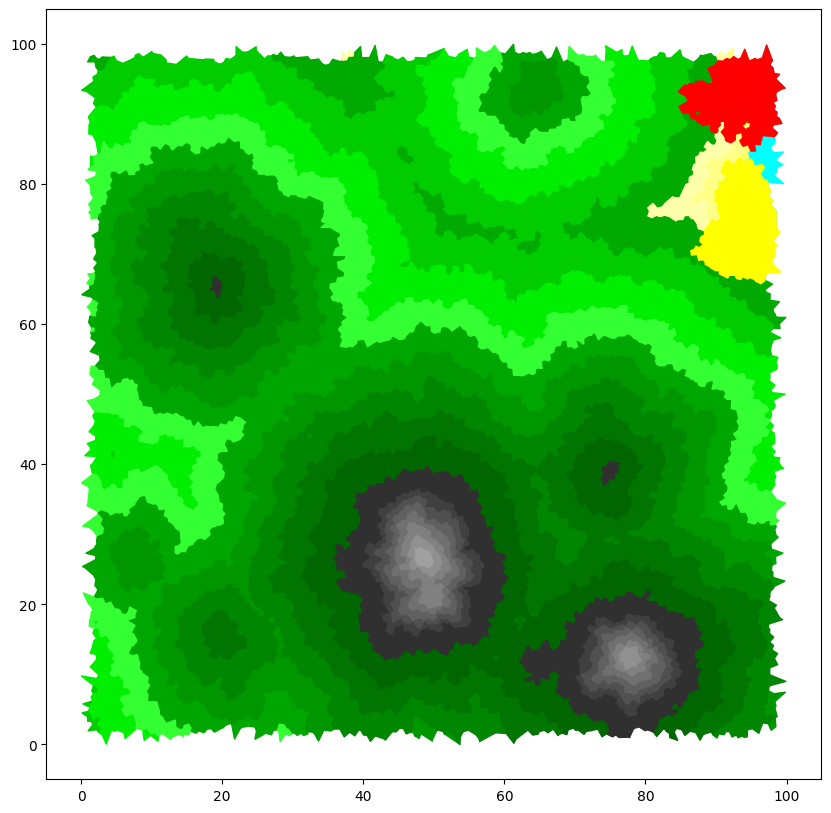

In [104]:
fig, ax = plt.subplots(1)
deep = []
water = []
hills = []
plains = []
beach = []
mountains = []

for i in groups:
    if i > 40:
        mountains.append(PatchCollection(groups[i]))
    elif i > 25:
        hills.append(PatchCollection(groups[i]))
    elif i > 10:
        plains.append(PatchCollection(groups[i]))
    elif i > 5:
        beach.append(PatchCollection(groups[i]))
    elif i > 0:
        water.append(PatchCollection(groups[i]))
    else:
        deep.append(PatchCollection(groups[i]))

mountains_colours = ["#FFFFFF","#F4F4F4","#F0F0F0","#E0E0E0","#D0D0D0","#C0C0C0","#B0B0B0","#A0A0A0","#909090","#808080","#707070","#606060","#505050","#404040","#303030","#303030","#303030"]
mountains_colours = mountains_colours[::-1]
for count, i in enumerate(mountains):
    ax.add_collection(i)
    i.set_color(mountains_colours[count])

hills_colours = ["#006600","#006600","#006600","#007600","#007600","#007600","#008600","#008600","#008600","#009600","#009600","#009600","#00A600","#00A600","#00A600"]
hills_colours = hills_colours[::-1]
for count, i in enumerate(hills):
    ax.add_collection(i)
    i.set_color(hills_colours[count])

plains_colours = [["#00AA00"],["#00AA00"],["#00AA00"],["#00AA00"],["#00CC00"],["#00CC00"],["#00CC00"],["#00CC00"],["#00EE00"],["#00EE00"],["#00EE00"],["#00EE00"],["#33FF33"],["#33FF33"],["#33FF33"],["#33FF33"]]
for count, i in enumerate(plains):
    ax.add_collection(i)
    i.set_color(plains_colours[count])

beach_colours = [["#FFFF66"],["#FFFF88"],["#FFFF88"],["#FFFFAA"],["#FFFFAA"]]
for count, i in enumerate(beach):
    ax.add_collection(i)
    i.set_color(beach_colours[count])

for i in water:
    ax.add_collection(i)
    i.set_color("#00FFFF")

for i in deep:
    ax.add_collection(i)
    i.set_color("#0000FF")


district_center = []
district_shop = []

for i in cell_network.nodes:
    district = cell_network.nodes[i]["district"]
    if(check(lloyd.vertices[lloyd.regions[i]])):
        if district == "center":
            district_center.append(Polygon(lloyd.vertices[lloyd.regions[i]]))
        if district == "shop":
            print(1)
            district_shop.append(Polygon(lloyd.vertices[lloyd.regions[i]]))

dtac = PatchCollection(district_center)
ax.add_collection(dtac)
dtac.set_color("#ff0000")

dtas = PatchCollection(district_shop)
ax.add_collection(dtas)
dtas.set_color("#ffff00")

ax.autoscale_view()
fig.set_size_inches(10, 10)


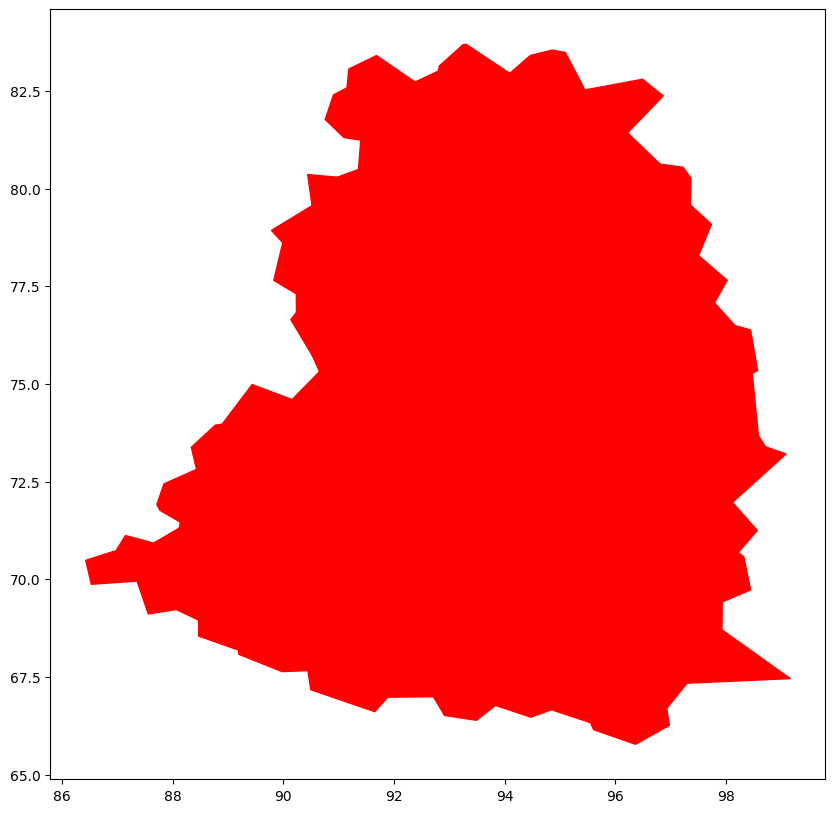

In [106]:
fig, ax = plt.subplots(1)
district_center = []

for i in cell_network.nodes:
    district = cell_network.nodes[i]["district"]
    if(check(lloyd.vertices[lloyd.regions[i]])):
        if district == "shop":
            district_center.append(Polygon(lloyd.vertices[lloyd.regions[i]]))

dtac = PatchCollection(district_center)
ax.add_collection(dtac)
dtac.set_color("#ff0000")

ax.autoscale_view()
fig.set_size_inches(10, 10)